In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.
/home/roebius/pj/p3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
cfg = tf.ConfigProto()
cfg.gpu_options.allow_growth = True
sess = tf.Session(config=cfg)

In [3]:
a = tf.placeholder("float")
b = tf.placeholder("float")
y = tf.multiply(a, b)

print (sess.run(y, feed_dict={a: 3, b: 3}))

9.0


## Simple regression

In [4]:
num_points = 1000
x_data= np.random.normal(0.0, 0.55, (num_points,))
y_data= x_data * 0.1 + 0.3 + np.random.normal(0.0, 0.03, (num_points,))

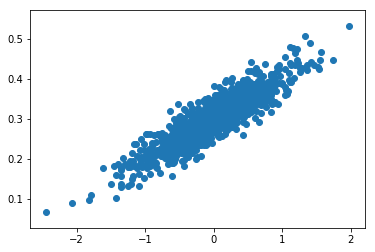

In [5]:
plt.scatter(x_data, y_data);

In [6]:
# - Adapted from the original code in order to have a working example 
x = tf.placeholder("float32")
y = tf.placeholder("float32")
W = tf.Variable(np.random.randn())
b = tf.Variable(np.random.randn())
y_pred = tf.add(tf.multiply(x, W), b)

loss = tf.reduce_mean(tf.square(y_pred - y))
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

In [7]:
init = tf.global_variables_initializer()

In [8]:
sess = tf.InteractiveSession(config=cfg)

In [9]:
init.run()
for step in range(8):
    train.run(feed_dict = {x:x_data, y:y_data}, session=sess)
    print (step, W.eval(), b.eval())

0 -0.366857 0.284109
1 -0.213791 0.289958
2 -0.110859 0.293872
3 -0.0416396 0.296505
4 0.00490802 0.298275
5 0.0362099 0.299466
6 0.0572594 0.300266
7 0.0714145 0.300805


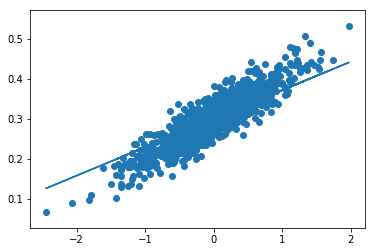

In [10]:
plt.scatter(x_data, y_data)
plt.plot(x_data, W.eval() * x_data + b.eval());

## Variable scope

In [11]:
tf.reset_default_graph()

In [12]:
with tf.variable_scope("foo"):
    v = tf.get_variable("v", [2,3])
v.name

'foo/v:0'

In [13]:
v.get_shape()

TensorShape([Dimension(2), Dimension(3)])

In [14]:
with tf.variable_scope("foo", reuse=True):
 v1 = tf.get_variable("v", [2,3])

In [15]:
v1==v

True

In [16]:
v2 = tf.get_variable("v2", [1])

In [17]:
v2.name

'v2:0'

## K-means clustering

In [18]:
def plot_data(data, centroids):
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        plt.scatter(samples[:,0], samples[:,1], c=colour[i])
        plt.plot(centroid[0], centroid[1], markersize=15, marker="x", color='k', mew=10)
        plt.plot(centroid[0], centroid[1], markersize=10, marker="x", color='m', mew=5)
    plt.show()

In [19]:
n_clusters=10
n_samples =250
centroids = np.random.uniform(-35, 35, (n_clusters, 2))
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples)
           for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

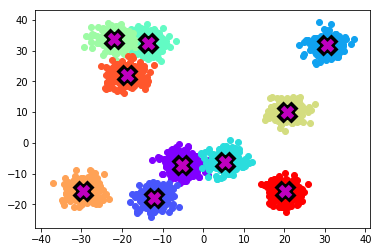

In [20]:
plot_data(data, centroids)

In [21]:
# Numpy Version
def find_initial_centroids_numpy(data, k):
    r_index = np.random.randint(data.shape[0])
    r = data[r_index, :][np.newaxis]
    initial_centroids = []
    for i in range(k):
        diff = data - np.expand_dims(r,1)
        dist = np.linalg.norm(diff, axis=2)  # 100x2  5x2 --> 100x5x2 --> 100x5
        farthest_index = np.argmax(np.min(dist, axis=0))
        farthest_point = data[farthest_index]
        initial_centroids.append(farthest_point)
        r = np.array(initial_centroids)
    return r

In [22]:
def find_initial_centroids(data, k):
    r_index = tf.random_uniform([1], 0, tf.shape(data)[0], dtype=tf.int32)
    r = tf.expand_dims(data[tf.squeeze(r_index)], dim=1)
    initial_centroids = []
    for i in range(k):
        diff = tf.squared_difference(tf.expand_dims(data, 0), tf.expand_dims(r,1))
        dist = tf.reduce_sum(diff, axis=2)
        farthest_index = tf.argmax(tf.reduce_min(dist, axis=0), 0)
        farthest_point = data[tf.to_int32(farthest_index)]
        initial_centroids.append(farthest_point)
#         r = tf.pack(initial_centroids)  # - tf.pack obsolete 
        r = tf.stack(initial_centroids)
    return r

In [23]:
samples = tf.placeholder(tf.float32, (None, None))

In [24]:
# - added this cell to initialize the graph
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [25]:
initial_centroids = find_initial_centroids(samples, n_clusters).eval({samples: data})

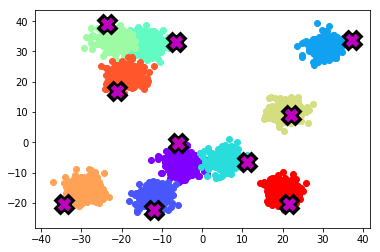

In [26]:
plot_data(data, initial_centroids)

In [27]:
initial_centroids = find_initial_centroids_numpy(data, n_clusters)

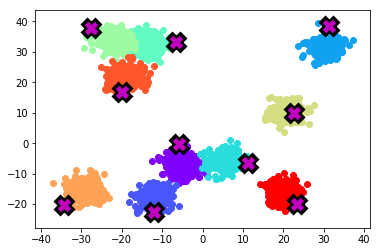

In [28]:
plot_data(data, initial_centroids)

In [29]:
def choose_random_centroids(samples, n_clusters):
    n_samples = tf.shape(samples)[0]
    random_indices = tf.random_shuffle(tf.range(0, n_samples))
    centroid_indices = random_indices[:n_clusters]
    return tf.gather(samples, centroid_indices)

In [30]:
def assign_to_nearest(samples, centroids):
    dim_dists = tf.squared_difference(tf.expand_dims(samples, 0), tf.expand_dims(centroids, 1))
    return tf.argmin(tf.reduce_sum(dim_dists , 2), 0)

In [31]:
def update_centroids(samples, nearest_indices, n_clusters):
    partitions = tf.dynamic_partition(samples, tf.to_int32(nearest_indices), n_clusters)
#     return tf.concat(0, [tf.expand_dims(tf.reduce_mean(partition, 0), 0) 
#                                   for partition in partitions])
    return tf.concat([tf.expand_dims(tf.reduce_mean(partition, 0), 0)  # tf.concat(values, axis) 
                                  for partition in partitions], 0)

In [32]:
initial_centroids = choose_random_centroids(samples, n_clusters).eval({samples: data})

In [33]:
curr_centroids = tf.Variable(initial_centroids)

In [34]:
nearest_indices = assign_to_nearest(samples, curr_centroids)
updated_centroids = update_centroids(samples, nearest_indices, n_clusters)

In [35]:
tf.global_variables_initializer().run()

In [36]:
c = initial_centroids
for i in range(10):
    #TODO animate
    c2 = curr_centroids.assign(updated_centroids).eval({samples: data})
    if np.allclose(c,c2):
        break
    c=c2

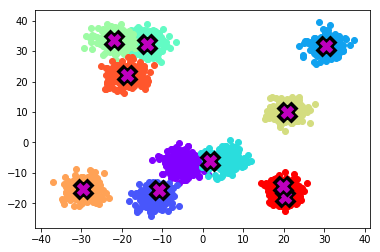

In [37]:
plot_data(data, curr_centroids.eval())

## Tf->Keras LR (# - working?)

In [38]:
# - Original (Keras 1)
# class LinRegr(Layer):
#     def __init__(self, **kwargs):
#         super(LinRegr, self).__init__(**kwargs)

#     def build(self, input_shape):
#         input_dims = input_shape[1:]
#         self.W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
#         self.b = tf.Variable(tf.zeros([1]))
#         self.built = True

#     def call(self, x, mask=None):
#         return self.W * x + self.b
    
#     def get_output_shape_for(self, input_shape):
#         return input_shape

# - Keras 2
class LinRegr(Layer):
    def __init__(self, **kwargs):
        super(LinRegr, self).__init__(**kwargs)

    def build(self, input_shape):
        input_dims = input_shape[1:]
        self.W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
        self.b = tf.Variable(tf.zeros([1]))
        self.trainable_weights=[self.W, self.b]  # - Without this line there would be no trainable parameters
        super(LinRegr, self).build(input_shape)  # - Could be just "self.built = True" 

    def call(self, x, mask=None):
        return self.W * x + self.b
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [39]:
inp = Input((1,))
res = LinRegr()(inp)

In [40]:
model = Model(inp, res)

In [41]:
model.compile('adam', 'mse')

In [42]:
model.fit(x_data, y_data, verbose=2, epochs=10)

Epoch 1/10
0s - loss: 0.2806
Epoch 2/10
0s - loss: 0.2479
Epoch 3/10
0s - loss: 0.2186
Epoch 4/10
0s - loss: 0.1925
Epoch 5/10
0s - loss: 0.1700
Epoch 6/10
0s - loss: 0.1500
Epoch 7/10
0s - loss: 0.1327
Epoch 8/10
0s - loss: 0.1172
Epoch 9/10
0s - loss: 0.1037
Epoch 10/10
0s - loss: 0.0917
